#### CPS matching observations one year apart

January 2, 2018

----

To Do:

Refactor and clean up code. Add comments. Parameterize!

Refactoring:

* Read cps feather file only once per year.

* Filter dataframe columns when reading.

In [1]:
# Import packages and set preliminaries
import pandas as pd
import numpy as np
import os

os.chdir('/home/brian/Documents/CPS/')

In [2]:
# Calculate disabled to work flow
data = pd.DataFrame()

# For each year calculate change over year before
for year in list(range(1995, 2019)):

    # Load year one
    df1 = (pd.read_feather(f'data/clean/cps{year-1}.ft')
             .query('HRMIS < 5 and 23 <= AGE <= 57'))

    # Generate flow1 variable
    df1['flow1'] = np.where(df1['PEMLR'].isin([3,4]), 1, 0)

    # Generate unique ID
    df1['UID'] = (df1['STATE'].astype(str) + 
                  df1['HRHHID'].astype(str) + 
                  df1['HRHHID2'].astype(str) + 
                  df1['PULINENO'].astype(str))

    # Fix year if needed
    if 'HRYEAR' in df1.keys():
        df1['HRYEAR4'] = df1['HRYEAR'] + 1900

    if year > 1998:
    # Filter column-wise
        df1 = df1[['UID','HRMONTH','HRYEAR4','HRMIS','AGE','flow1', 
                   'PWSSWGT', 'PWCMPWGT', 'FEMALE','WBHAO','STATE']]
    else:
        df1 = df1[['UID','HRMONTH','HRYEAR4','HRMIS','AGE','flow1', 
                   'PWSSWGT', 'FEMALE','WBHAO','STATE']]

    # Load year two
    df2 = (pd.read_feather(f'data/clean/cps{year}.ft')
             .query('HRMIS > 4 and 23 <= AGE <= 57'))

    # Generate flow2 variable
    df2['flow2'] = np.where(df2['PEMLR'] < 3, 1, 0)

    # Generate unique ID
    df2['UID'] = (df2['STATE'].astype(str) + 
                  df2['HRHHID'].astype(str) + 
                  df2['HRHHID2'].astype(str) + 
                  df2['PULINENO'].astype(str))

    # Fix year if needed
    if 'HRYEAR' in df2.keys():
        df2['HRYEAR4'] = df2['HRYEAR'] + 1900

    if year > 1998:
    # Filter column-wise
        df2 = df2[['UID','HRMONTH','HRYEAR4','HRMIS','AGE','flow2', 
                   'PWSSWGT', 'PWCMPWGT', 'FEMALE','WBHAO','STATE']]
    else:
        df2 = df2[['UID','HRMONTH','HRYEAR4','HRMIS','AGE','flow2', 
                   'PWSSWGT', 'FEMALE','WBHAO','STATE']]

    # List of months to loop over 
    mos = list(range(1, max(df2['HRMONTH']) + 1))

    # Loop over the months
    for mo in mos:

        # Generate merge groups
        g1 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 1)]
        g5 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 5)]
        g2 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 2)]
        g6 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 6)]
        g3 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 3)]
        g7 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 7)]
        g4 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 4)]
        g8 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 8)]    

        # Naive merge
        naive = (pd.merge(g1, g5, on='UID', how='inner').append(
                 pd.merge(g2, g6, on='UID', how='inner')).append(
                 pd.merge(g3, g7, on='UID', how='inner')).append(
                 pd.merge(g4, g8, on='UID', how='inner')))    

        # Filter by SRA
        mdata = naive[(naive['FEMALE_x'] == naive['FEMALE_y']) &
                      (naive['WBHAO_x'] == naive['WBHAO_y']) &
                      ((naive['AGE_x'] <= naive['AGE_y'] + 1) |
                      (naive['AGE_y'] >= naive['AGE_x']))]   

        mdata = mdata[mdata['AGE_y'].between(25, 54)]

        if year > 1998:
            mdata['WGT'] = mdata['PWCMPWGT_y']
        else:
            mdata['WGT'] = mdata['PWSSWGT_y']
        
        # Calculate outflow
        of = mdata[(mdata['flow1']==1) & (mdata['flow2']==1)]['WGT'].sum()

        # Calculate total
        tot = mdata[(mdata['flow1']==1)]['WGT'].sum()

        # Print share
        data.at[pd.to_datetime(f'{year}-{mo}-01'), 'Share'] = (of/tot) * 100

/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in float_scalars


In [3]:
%matplotlib inline
result = data.rolling(12).mean()

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
#plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [5]:
result.iloc[-1]

Share    56.244012
Name: 2018-11-01 00:00:00, dtype: float64

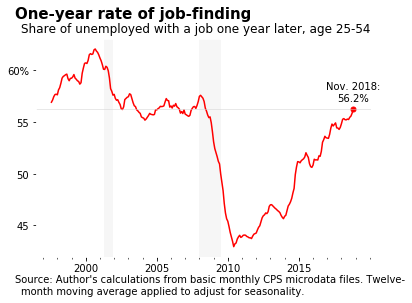

In [7]:
result.plot(color='red', legend=None, figsize=(6, 4), zorder=2)
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='lightgray', alpha=0.2, zorder=1)
plt.scatter([result.index[-1]], [result.iloc[-1]], color='red', s=25)
plt.text(result.index[-1], 57, 'Nov. 2018:\n56.2%', ha='center')
plt.yticks([45.0, 50.0, 55.0, 60.0], ['45', '50', '55', '60%'])
plt.xticks(['2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01'], ['2000', '2005', '2010', '2015'])
plt.axhline(y=56.244012, color='lightgray', linewidth=0.5)    

# add title and footer
plt.text('1995-01-01', 65, 'One-year rate of job-finding', 
          fontsize=15, weight='bold')

plt.text('1995-06-01', 63.7, "Share of unemployed with a job one year later, age 25-54", 
          fontsize=12)

plt.text('1995-01-01', 39.5, "Source: Author's calculations from basic monthly CPS microdata files. Twelve-")
plt.text('1995-06-01', 38.4, 'month moving average applied to adjust for seasonality.')

plt.savefig('Jobfinding.png', bbox_inches='tight')

plt.show()